<h1 align="center" style="color:#6699ff"> DataCamp IEEE Fraud Detection </h1>

<img src="https://github.com/DataCampM2DSSAF/suivi-du-data-camp-equipe-tchouacheu-niang-chokki/blob/master/img/credit-card-fraud-detection.png?raw=true" width="800" align="right">

#  <a style="color:#6699ff"> Team </a>
- <a style="color:#6699ff">Mohamed NIANG </a>
- <a style="color:#6699ff">Fernanda Tchouacheu </a>
- <a style="color:#6699ff">Hypolite Chokki </a>

# <a style="color:#6699ff">  Table of Contents</a> 

<a style="color:#6699ff"> I. Preprocessing</a>

<a style="color:#6699ff"> II. Deep leaning Models</a>

<div align='left'><font size='4' color='#229954'>Load package</font></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import itertools
from scipy import interp
from matplotlib import rcParams

from time import time
import datetime

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve

from keras.layers import Concatenate, Input, Dense, Embedding, Flatten, Dropout, BatchNormalization, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.optimizers import  Adam
import keras.backend as k

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import os
os.chdir('/kaggle/input/ieeedatapreprocessing') # Set working directory
print(os.listdir('/kaggle/input/ieeedatapreprocessing'))

Using TensorFlow backend.


['sample_submission.csv', 'train_df.pkl', 'test_df.pkl']


<div align='left'><font size='4' color='#229954'>Reducing memory usage</font></div>

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

<div align='left'><font size='4' color='#229954'>Load data</font></div>

In [3]:
%%time
train_df = reduce_mem_usage(pd.read_pickle('train_df.pkl'))
y_train = train_df['isFraud'].astype('uint8')
test_df = reduce_mem_usage(pd.read_pickle('test_df.pkl'))
print ("Data is loaded!")

Memory usage of dataframe is 1022.74 MB
Memory usage after optimization is: 272.02 MB
Decreased by 73.4%
Memory usage of dataframe is 877.52 MB
Memory usage after optimization is: 237.26 MB
Decreased by 73.0%
Data is loaded!
CPU times: user 26.2 s, sys: 37.9 s, total: 1min 4s
Wall time: 1min 5s


In [4]:
print('train_transaction shape is {}'.format(train_df.shape))
print('test_transaction shape is {}'.format(test_df.shape))

train_transaction shape is (590540, 226)
test_transaction shape is (506691, 226)


<div align='left'><font size='4' color='#229954'>Target variable: imbalance problem</font></div>

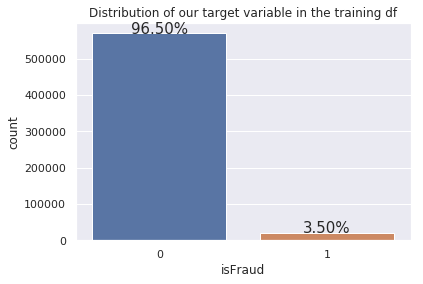

In [5]:
count = sns.countplot(y_train)
plt.title('Distribution of our target variable in the training df')
total = train_df.shape[0]
for p in count.patches:
    height = p.get_height()
    count.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15)

# <a style="color:#6699ff"> I. Preprocessing</a>

Dropping time since this likely isnt something we want our model to directly learn from.

In [6]:
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [7]:
train_df['nulls1'] = train_df.isna().sum(axis=1)
test_df['nulls1'] = test_df.isna().sum(axis=1)

In [8]:
train_df = train_df.drop(["TransactionDT"], axis = 1)
test_df = test_df.drop(["TransactionDT"], axis = 1)

In [9]:
train_df

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V314,V315,V316,V317,V318,V319,V320,V321,EMAILP,nulls1
0,2987000,0,68.500000,4,13926,-999.0,150.0,2,142.0,2,...,0.0000,0.0000,0.0,117.0,0.0,0.000000,0.000000,0.000000,0,0
1,2987001,0,29.000000,4,2755,404.0,150.0,3,102.0,2,...,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,5,0
2,2987002,0,59.000000,4,4663,490.0,150.0,4,166.0,3,...,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,6,0
3,2987003,0,50.000000,4,18132,567.0,150.0,3,117.0,3,...,0.0000,0.0000,50.0,1404.0,790.0,0.000000,0.000000,0.000000,9,0
4,2987004,0,50.000000,1,4497,514.0,150.0,3,102.0,2,...,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,49.000000,4,6550,-999.0,150.0,4,226.0,3,...,47.9375,47.9375,0.0,0.0,0.0,0.000000,0.000000,0.000000,0,0
590536,3577536,0,39.500000,4,10444,225.0,150.0,3,224.0,3,...,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,5,0
590537,3577537,0,30.953125,4,12037,595.0,150.0,3,224.0,3,...,0.0000,0.0000,0.0,0.0,0.0,0.000000,0.000000,0.000000,5,0
590538,3577538,0,117.000000,4,7826,481.0,150.0,3,224.0,3,...,669.5000,317.5000,0.0,2234.0,0.0,0.000000,0.000000,0.000000,1,0


In [10]:
test_df

,TransactionID,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V314,V315,V316,V317,V318,V319,V320,V321,EMAILP,nulls1
0,3663549,0,31.953125,4,10409,111.0,150.0,4,226.0,3,...,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,5,0
1,3663550,0,49.000000,4,4272,111.0,150.0,4,226.0,3,...,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,3663551,0,171.000000,4,4476,574.0,150.0,4,226.0,3,...,0.00000,0.00000,0.0,0.0,0.0,0.0,263.0,0.0,6,0
3,3663552,0,285.000000,4,10989,360.0,150.0,4,166.0,3,...,282.50000,282.50000,0.0,0.0,0.0,0.0,0.0,0.0,5,0
4,3663553,0,67.937500,4,18018,452.0,150.0,3,117.0,3,...,183.87500,67.93750,0.0,0.0,0.0,0.0,0.0,0.0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,0,94.687500,0,13832,375.0,185.0,3,224.0,3,...,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,5,0
506687,4170236,0,12.171875,0,3154,408.0,185.0,3,224.0,3,...,31.71875,31.71875,0.0,0.0,0.0,0.0,0.0,0.0,6,0
506688,4170237,0,49.000000,4,16661,490.0,150.0,4,226.0,3,...,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,6,0
506689,4170238,0,202.000000,4,16621,516.0,150.0,3,224.0,3,...,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,6,0


In [11]:
for c1, c2 in train_df.dtypes.reset_index().values:
    if c2=='O':
        train_df[c1] = train_df[c1].map(lambda x: str(x).lower())
        test_df[c1] = test_df[c1].map(lambda x: str(x).lower())

<div align='left'><font size='4' color='#229954'>Numerical and Categorical</font></div> 

<div style="text-align: justify"> Listing off and categorizing the various variables available to us. We have numerical and categoricals. We will treat both of these slightly differently later. </div>

In [12]:
numerical = ["TransactionAmt", "nulls1", "dist1", "dist2"] + ["C" + str(i) for i in range(1, 15)] + \
            ["D" + str(i) for i in range(1, 16)] + \
            ["V" + str(i) for i in range(1, 340)]

categorical = ["ProductCD", "card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2",
               "P_emaildomain_bin", "P_emaildomain_suffix", "R_emaildomain_bin", "R_emaildomain_suffix",
               "P_emaildomain", "R_emaildomain",
              "DeviceInfo", "DeviceType"] + ["id_0" + str(i) for i in range(1, 10)] +\
                ["id_" + str(i) for i in range(10, 39)] + \
                 ["M" + str(i) for i in range(1, 10)]

<div style="text-align: justify"> We already dropped a lot of these features because in some trial and error it was shown that these caused rapid overfitting for some reason or otherwise introduced unnesecary noise into the data. We will make sure we only list the features we actually have still in the df now. </div>

In [13]:
numerical = [col for col in numerical if col in train_df.columns]
categorical = [col for col in categorical if col in train_df.columns]

<div align='left'><font size='4' color='#229954'>Label Encoding</font></div> 

<div style="text-align: justify"> We will take our categorical features fill the nans and assign them an integer ID per category and write down the number of total categories per column. We'll use this later in an embedding layer of the NN. </div>

In [14]:
# Label Encoding
category_counts = {}
for f in categorical:
    train_df[f] = train_df[f].replace("nan", "other")
    train_df[f] = train_df[f].replace(np.nan, "other")
    test_df[f] = test_df[f].replace("nan", "other")
    test_df[f] = test_df[f].replace(np.nan, "other")
    lbl = LabelEncoder()
    lbl.fit(list(train_df[f].values) + list(test_df[f].values))
    train_df[f] = lbl.transform(list(train_df[f].values))
    test_df[f] = lbl.transform(list(test_df[f].values))
    category_counts[f] = len(list(lbl.classes_)) + 1

<div align='left'><font size='4' color='#229954'>Numerical Scaling</font></div> 

<div style="text-align: justify"> Now we will do some scaling of the data so that it will be in a more NN friendly format. First we will do log1p for any values that are above 100 and not below 0. This is in order to scale down any numerical variables that might have some extremely high values that screws up the statistics of the standard scaler. </div>

<br>

<div style="text-align: justify"> After that we will pass them through the standard scaler so that the values have a normal mean and std. This makes the NN converge signficantly faster and prevents any blowouts. </div>

In [15]:
for column in numerical:
    scaler = StandardScaler()
    if train_df[column].max() > 100 and train_df[column].min() >= 0:
        train_df[column] = np.log1p(train_df[column])
        test_df[column] = np.log1p(test_df[column])
    scaler.fit(np.concatenate([train_df[column].values.reshape(-1,1), test_df[column].values.reshape(-1,1)]))
    train_df[column] = scaler.transform(train_df[column].values.reshape(-1,1))
    test_df[column] = scaler.transform(test_df[column].values.reshape(-1,1))

In [16]:
target = 'isFraud'

# <a style="color:#6699ff"> II. Deep leaning Models</a>

<div align='left'><font size='4' color='#229954'>Splitting to train and validation</font></div>

- We will now split the train dataset into train and validation set with stratification to tackle unbalanced classes.
- We will keeep 20% of data for validation.

In [17]:
tr_df, val_df = train_test_split(train_df, test_size = 0.2, random_state = 42, stratify = train_df[target])

In [18]:
print(tr_df.shape)
print(val_df.shape)

(472432, 227)
(118108, 227)


In [19]:
def get_input_features(df):
    X = {'numerical':np.array(df[numerical])}
    for cat in categorical:
        X[cat] = np.array(df[cat])
    return X

<div align='left'><font size='4' color='#229954'>Neural Network Model</font></div>

 <div style="text-align: justify"> Our neural network will be fairly standard. We will use the embedding layer for categoricals and the numericals will go through feed forward dense layers. </div>

<br>

 <div style="text-align: justify"> We create our embedding layers such that we have as many rows as we had categories and the dimension of the embedding is the log1p + 1 of the number of categories. So this means that categorical variables with very high cardinality will have more dimensions but not signficantly more so the information will still be compressed down to only about 13 dimensions and the smaller number of categories will be only 2-3. </div>

<br>

 <div style="text-align: justify"> We will then pass the embeddings through a spatial dropout layer which will drop dimensions within the embedding across batches and then flatten and concatenate. Then we will concatenate this to the numerical features and apply batch norm and then add some more dense layers after. </div>

In [20]:
categorical.remove("card1")

In [21]:
category_counts

{'ProductCD': 6,
 'card1': 17092,
 'card2': 503,
 'card3': 135,
 'card4': 6,
 'card5': 140,
 'card6': 6,
 'addr1': 443,
 'addr2': 95,
 'P_emaildomain': 62,
 'M1': 4,
 'M2': 4,
 'M3': 4,
 'M4': 5,
 'M5': 4,
 'M6': 4,
 'M7': 4,
 'M8': 4,
 'M9': 4}

In [22]:
k.clear_session()

In [23]:
categorical_inputs = []
for cat in categorical:
    categorical_inputs.append(Input(shape=[1], name=cat))

categorical_embeddings = []
for i, cat in enumerate(categorical):
    categorical_embeddings.append(
        Embedding(category_counts[cat], int(np.log1p(category_counts[cat]) + 1), name = cat + "_embed")(categorical_inputs[i]))

categorical_logits = Concatenate(name = "categorical_conc")([Flatten()(SpatialDropout1D(.1)(cat_emb)) for cat_emb in categorical_embeddings])

numerical_inputs = Input(shape=[tr_df[numerical].shape[1]], name = 'numerical')
numerical_logits = Dropout(.1)(numerical_inputs)

In [24]:
x = Concatenate()([
    categorical_logits, 
    numerical_logits,
])

In [25]:
x = BatchNormalization()(x)
x = Dense(200, activation = 'relu')(x)
x = Dropout(.2)(x)
x = Dense(100, activation = 'relu')(x)
x = Dropout(.2)(x)
out = Dense(1, activation = 'sigmoid')(x)

In [26]:
model = Model(inputs=categorical_inputs + [numerical_inputs],outputs=out)

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ProductCD (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
card2 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
card3 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
card4 (InputLayer)              (None, 1)            0                                            
____________________________________________________________________________________________

In [28]:
loss = "binary_crossentropy"
model.compile(optimizer=Adam(lr = 0.001), loss = loss)

We will then extract the features we actually want to pass to the NN.

In [29]:
X_train = get_input_features(tr_df)
X_valid = get_input_features(val_df)
X_test = get_input_features(test_df)
y_train = tr_df[target]
y_valid = val_df[target]

In [30]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, mode='auto', verbose = False)

In [31]:
best_score = 0
patience = 0

In [32]:
for i in range(100):
    if patience < 4:
        model_history = model.fit(X_train, y_train, validation_data = (X_valid,y_valid), batch_size = 1000, epochs = 1, verbose = 1)
        valid_preds = model.predict(X_valid, batch_size = 8000, verbose = True)
        score = roc_auc_score(y_valid, valid_preds)
        print(score)
        if score > best_score:
            model.save_weights("/kaggle/working/model.h5")
            best_score = score
            patience = 0
        else:
#             patience += 1
            pass

Train on 472432 samples, validate on 118108 samples
Epoch 1/1
118108/118108 [==============================] - 1s 9us/step
0.8831346445323398
Train on 472432 samples, validate on 118108 samples
Epoch 1/1
118108/118108 [==============================] - 1s 6us/step
0.9050219476374148
Train on 472432 samples, validate on 118108 samples
Epoch 1/1
118108/118108 [==============================] - 1s 6us/step
0.9110670332098225
Train on 472432 samples, validate on 118108 samples
Epoch 1/1
118108/118108 [==============================] - 1s 6us/step
0.9187497757046933
Train on 472432 samples, validate on 118108 samples
Epoch 1/1
118108/118108 [==============================] - 1s 5us/step
0.9232611468199795
Train on 472432 samples, validate on 118108 samples
Epoch 1/1
118108/118108 [==============================] - 1s 6us/step
0.9259507013643258
Train on 472432 samples, validate on 118108 samples
Epoch 1/1
118108/118108 [==============================] - 1s 6us/step
0.9250956560772392
Train 

In [33]:
model.load_weights("/kaggle/working/model.h5")

<div align='left'><font size='4' color='#229954'>Confusion matrix</font></div> 

In [34]:
# confusion matrix
# Predict the values from the validation dataset
y_pred = model.predict(X_valid, batch_size = 500, verbose = True) 

118108/118108 [==============================] - 2s 14us/step


In [35]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_valid, y_pred.round())

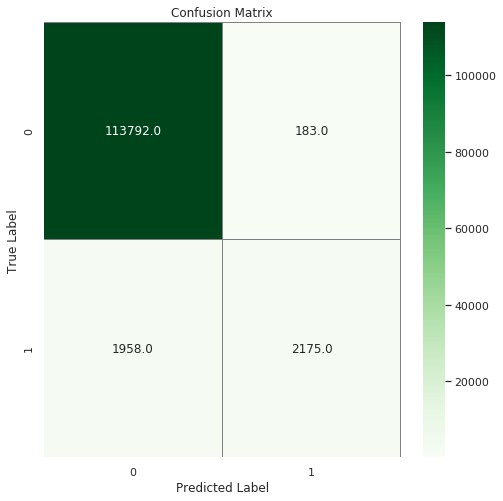

In [36]:
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<div align='left'><font size='4' color='#229954'>ROC curve and AUC</font></div> 

In [37]:
#Predict on test set
predictions_NN_prob = y_pred
predictions_NN_prob = predictions_NN_prob[:,0]

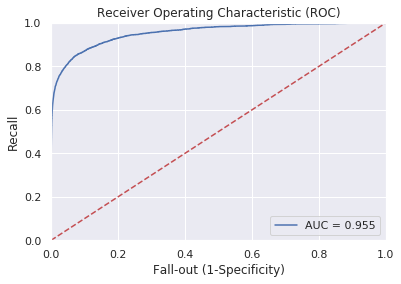

In [38]:
#Print Area Under Curve
false_positive_rate, recall, thresholds = roc_curve(y_valid, predictions_NN_prob)
roc_auc = auc(false_positive_rate, recall)
plt.figure()
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

<div align='left'><font size='4' color='#229954'>Twelfth submission using Neural Network</font></div> 

In [39]:
predictions = model.predict(X_test, batch_size = 2000, verbose = True)

506691/506691 [==============================] - 4s 7us/step


In [40]:
submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')
submission.isFraud = predictions
submission.head()

,isFraud
TransactionID,
3663549,1.135889e-03
3663550,1.117021e-03
3663551,3.703153e-08
3663552,3.055043e-03
3663553,5.673619e-04


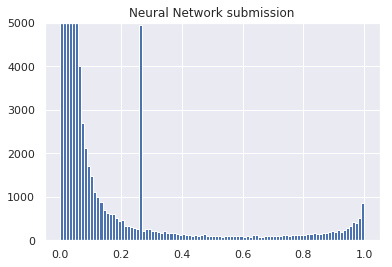

In [41]:
plt.hist(submission.isFraud,bins=100)
plt.ylim((0,5000))
plt.title('Neural Network submission')
plt.show()

In [42]:
submission.to_csv('/kaggle/working/neural_network_submission.csv')